<a href="https://colab.research.google.com/github/dgromann/SemComp_WS2018/blob/master/Tutorial5/Tutorial5_model_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lesson 0.0.0: Store this notebook! 

Go to "File" and make sure you store this file as a local copy to either GitHub or your Google Drive. If you do not have a Google account and also do not want to create one, please check Option C below. 

Option A) Google Drive WITH collaboration

If you want to work in a collaborative manner where each of you in the group can see each other's contributions, one of you needs to store the notebook in Google Drive and share it with the others. You share it by clicking on the SHARE button on the top right of this page and share the link with the "everyone who receives this link can edit" option with the other team members per e-mail, skype, or any other way you prefer.

If you work with others, keep in mind to always copy the code before you edit it and always indicate your name as a comment (e.g. #Dagmar ) in the cell that it is clear who wrote which part. I also recommend creating a new code cell for your contributions.

Option B) Github without collaboration

Collaborative functions are not available when storing the notebook in GitHub; you will see your own work but not that of others.


Option C) Download this notebook as ipynb (Jupyter notebook) or py (Python file)

To run either of these on your local machine requires the installation of the required programs, which for the first tutorial are Python and NLTK. This will become more as we continue on to machine learning (requiring sklearn) and deep learning (requiring tensorflow and/or pytorch). In Google Codelab all of these are provided and do not need to be installed locally.


# Lesson 1: Data cleaning and analysis 

Today we will work with the real-world data set of company e- mails called [Enron](http://www.cs.cmu.edu/~enron/). The Enron Corporation, an energy, commodity and service corporation, went bankrupt in 2001 as a result of fraudulent business practices. In total 0.5 million e-mails send by Enron executives between 2000 and 2002 were recorded and published along with financial information. The goal of processing this dataset with machine learning algorithms is to detect emails of interest which might be involved in fraudulent activities.

We do not have any labels for this dataset, this is, we do not know which messages are of interest and which are not. Thus, we need to cluster the messages. First, however, we need to upload the data and structure them in a format to enable clustering. To this end, we will upload the "enron.txt" file that contains 100 sample messages from the dataset. We need to separate the header and the body of the e-mails and for now, only store the Message-ID, the sender of each e-mail ("From: "), the receiver ("To: "), and the body.  Complete the provided function to this end..

In [2]:
import re
import string
import os
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward
from random import randint

from google.colab import files
uploaded = files.upload()

Saving enron.txt to enron.txt


## Exercise 1.1: 
Use the method below to complete the processing and cleaning of the data. Some **important additional hints**: 

*   messages are separated by lines with this string: `"--------Separator------------" ` 
*   the `header_re` variable provides a pattern that identifies header lines 
* filter the body by using `re.sub(r'[^a-zA-Z]', ' ', line)` to make sure your cleaned body dictionary only contains interesting  and useful information



In [5]:
# Some Regular Expresssions for processing e-mails
# Finding different types of linebreaks
linebreak = ["\n", "\r", "\r\n"]  # unix, mac, and DOS newlines

# Finding header lines
header_re = re.compile('([^:]+):\s(.*)')


#One possible version of how to parse e-mails
def parse_email(input_file):
    from_dict = {}
    to_dict = {}
    emails_body = {}
       
    # Exercise: Get the "From", "To", and body information from each message
    # you can use the regular expression above to find out which lines are 
    # part of the header and which ones are not 
    # Each message is separated from the others by containing 
    # "--------Separator------------" in the line 
    
    body = ""
    doneWithHeader = False
    originalMessage = False
    headers = {}
    for line in input_file.readlines():
      if doneWithHeader == False:
          if header_re.match(line) != None or ":" in line:
              if "Message-ID:" in line: 
                message_id = line.split(".")[0].replace("Message-ID: <", "")
              if line.startswith("From: "):
                  from_dict[message_id] = line.split(":")[1].replace("\n", "")
              if line.startswith("To: "):
                  to_dict[message_id] = line.split(":")[1].replace("\n", "")
          if line in linebreak:
              doneWithHeader = True
      elif "Original Message" in line or "Forwarded by" in line:
          originalMessage = True
      elif originalMessage == True:
          if line in linebreak:
              originalMessage = False
      elif "--------Separator------------" in line: 
        emails_body[message_id] = body
        doneWithHeader = False
      else:
          line = re.sub(r'[^a-zA-Z]', ' ', line)
          body += line
    emails_body[message_id] = body
    return emails_body, from_dict, to_dict
  
enron = open("enron.txt", "r")
body, from_dict, to_dict = parse_email(enron)
print("Length of from_dict: ", len(from_dict), "Length of to_dict: ", len(to_dict), "Length of body_dict: ", len(body))


Length of from_dict:  99 Length of to_dict:  97 Length of body_dict:  99


## Principal Component Analysis for Data Visualization

It is important to understand the data. A good starting point after having looked at the actual messages and after data cleaning, is to visualize the data. We cannot easily visualize the many features (words, header information, etc.) of each messages. We need to reduce the dimension to two in order to be able to visualize them easily. 

**Principal Components Analysis (PCA) ** is a dimensionality reduction algorithm that can be used to significantly speed up your unsupervised feature learning algorithm. It finds a sequence of linear combination of the variables called the principal components that explain the maximum variance and summarize the most information in the data and are mutually uncorrelated.

The goal of PCA is to find the most relevant set of variables and linearly combine this set to a single variable called the principal component.


1.   The first principal component has the highest variance across data
2.   The second principal component is uncorrelated with the first and also has high variance 

PCA will find a lower-dimensional subspace onto which to project our data. Let's look at an example dataset (Source: http://ufldl.stanford.edu/wiki/index.php/PCA):

![alt text](http://ufldl.stanford.edu/wiki/images/thumb/b/ba/PCA-rawdata.png/800px-PCA-rawdata.png)

From this visualization it appears that the data have two main directions of variation: u1 being the primary direction of variation  and u2 being the secondary:

![alt text](http://ufldl.stanford.edu/wiki/images/thumb/b/b4/PCA-u1.png/800px-PCA-u1.png)

In terms of calculation, we need to generate the following matrix in order to find the directions u1 and u2:

![alt text](http://ufldl.stanford.edu/wiki/images/math/d/a/9/da9b50ec05dbe4ae513e4f52093b8342.png)

The principal direction of variation of the data turns out to be the principal eigenvector of this matrix "Sigma" and the second top direction of variation is the second eigenvector of this matrix. Depending on the number of dimensions you wish to reduce to, you can use the corresponding numbers of eigenvectors from this matrix to transform your data. Generally the eigenvectors of Sigma are represented as a matrix on their one called U. 

If you wish to reduce to only one dimension, your reduction would consist in:
![alt text](http://ufldl.stanford.edu/wiki/images/math/c/d/0/cd047246fd68f6d52b2fd068e063c0ef.png)


In [0]:
def plot_clustering_results(X, clf, n_clusters):
    # Let's plot this with matplotlib to visualize it.
    # First we need to make 2D coordinates from the sparse matrix.
    X_dense = X.todense()
    pca = PCA(n_components=2).fit(X_dense)
    coords = pca.transform(X_dense)

    # Lets plot it again, but this time we add some color to it.
    # This array needs to be at least the length of the n_clusters.
    label_colors = []
    for i in range(n_clusters):
        label_colors.append('#%06X' % randint(0, 0xFFFFFF))
    colors = [label_colors[i] for i in labels]

    plt.scatter(coords[:, 0], coords[:, 1], c=colors)
    # Plot the cluster centers
    centroids = clf.cluster_centers_
    centroid_coords = pca.transform(centroids)
    plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
    plt.title("Visualization of k-means clustering results ")
    plt.show()

## Exercise 1.2: Applied PCA for Visualization

Use the provided "plot_clustering_results" in order to obtain a first visualization of the enron dataset. To to this, we first need to turn our words into features and then run PCA on them.

Vocabulary of TfidfVectorizer without stop words:  {'calendar': 295, 'tracy': 2403, 'arthur': 127, 'ect': 729, 'dan': 561, 'leff': 1343, 'hou': 1121, 'ees': 742, 'jeffrey': 1228, 'shankman': 2153, 'louise': 1411, 'kitchen': 1299, 'steven': 2264, 'kean': 1275, 'rex': 2032, 'shelby': 2161, 'enron': 787, 'communications': 428, 'tod': 2390, 'lindholm': 1370, 'jeff': 1226, 'donahue': 686, 'jay': 1222, 'fitzgerald': 914, 'ny': 1641, 'richard': 2037, 'dimichele': 646, 'brian': 260, 'redmond': 1951, 'jeremy': 1230, 'blachman': 226, 'michael': 1522, 'kopper': 1305, 'cc': 330, 'sandy': 2088, 'roberts': 2051, 'corp': 515, 'subject': 2284, 'welcome': 2539, 'new': 1605, 'associates': 141, 'reception': 1943, 'fyi': 959, 'dasovich': 565, 'sent': 2138, 'pm': 1791, 'alan': 67, 'comnes': 429, 'pdx': 1741, 'angela': 92, 'schwarz': 2110, 'beverly': 214, 'aden': 39, 'votaw': 2502, 'brenda': 256, 'barreda': 180, 'carol': 315, 'moffett': 1550, 'cathy': 325, 'corbin': 513, 'chris': 362, 'foster': 937, 'christ

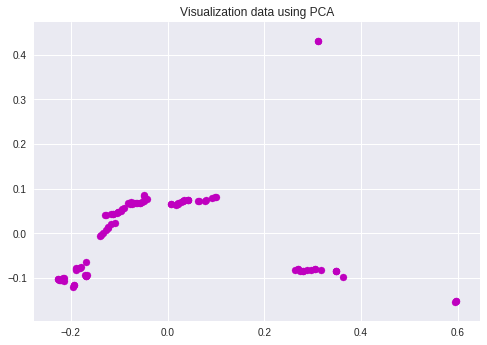

This is a little extra code to get some better understanding for TF-IDF
These are the features with the lowest Inverse Document Frequency (IDF; Document Frequencies are "penalized" with IDF for appearing in many emails, i.e., made lower)
['ect' 'rex' 'subject' 'reception' 'redmond' 'hou' 'tod' 'blachman' 'jay'
 'enron' 'steven' 'jeff' 'tracy' 'roberts' 'shankman' 'jeffrey' 'arthur'
 'ees' 'michael' 'jeremy']
These are the features with the highest IDF, so they are likely to appear in very few if not only one email: 
['deborah' 'kanner' 'copies' 'liberty' 'mp' 'bogorad' 'sliz' 'mkanner'
 'allowing' 'amend' 'mirrors' 'dsliz' 'words' 'barton' 'construct'
 'cingebretson' 'cirrincione' 'drafting' 'bogoradc' 'peters']

Maximum TF-IDF values throughout the dataset: 
['steven' 'ena' 'kean' 'pm' 'comments' 'ccsi' 'draft' 'attached' 'cc' 'na'
 'subject' 'corp' 'development' 'enronxgate' 'com' 'communications' 'hou'
 'ect' 'ees' 'enron']
Values with the lowest TF-IDF values:
['dqe' 'mcquade' 'mcc

In [7]:
# Exercise: Convert body to matrix of TF-IDF features and remove stop words
# Using a parameter of the TF-IDF Vectorizer
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(body.values())
print("Vocabulary of TfidfVectorizer without stop words: ", vect.vocabulary_)

# Exercise: change the following variable "X" to the name of your matrix and plot the results
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.title("Visualization data using PCA")
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

# Exercise: use your TF-IDF feature matrix to get the 20 top keywords of all e-mails (function "name of your TfidfVectorizer".get_feature_names() and then
#argsort only supports small to large sorting; to change this order we use -1 in the following line
feature_names = np.array(vect.get_feature_names())
sort = np.argsort(vect.idf_)
top_n = 20
print("This is a little extra code to get some better understanding for TF-IDF")
print("These are the features with the lowest Inverse Document Frequency (IDF; Document Frequencies are \"penalized\" with IDF for appearing in many emails, i.e., made lower)")
print((feature_names[sort[:top_n]]))
print("These are the features with the highest IDF, so they are likely to appear in very few if not only one email: ")
print(feature_names[sort[-top_n:]])
print()

max_values = X.max(axis=0).toarray().ravel()
sort_by_tfidf = max_values.argsort()
print("Maximum TF-IDF values throughout the dataset: ")
print(feature_names[sort_by_tfidf[-top_n:]])

print("Values with the lowest TF-IDF values:")
print(feature_names[sort_by_tfidf[:top_n]])
print()

# Lesson 2: Clustering

This part will practically apply the k-means cluster to the above enron dataset.

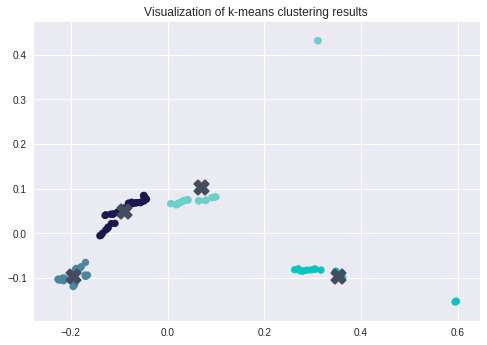

Top terms per cluster:
Cluster 0:
enron,ees,hou,ect,com,corp,development,subject,cc,na,enronxgate,attached,draft,communications,comments,ccsi,kean,pm,steven,mark,
Cluster 1:
ees,enron,hou,ect,enronxgate,communications,com,na,corp,development,richard,subject,mark,james,jeff,cc,michael,kathy,sfo,euenronxgate,
Cluster 2:
enron,ees,hou,ect,communications,development,enronxgate,corp,com,na,subject,cc,richard,mark,jeff,kean,steven,james,karen,michael,
Cluster 3:
enron,ees,hou,ect,corp,development,enronxgate,communications,com,subject,na,cc,attached,comments,jeff,kean,steven,mark,draft,pm,


In [8]:
# Exercise : Perform clustering on the data using k-means
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = kmeans.fit_predict(X)

# Exercise: Plot the resulting clusters using the function plot_clustering_results (see above)
plot_clustering_results(X, kmeans, n_clusters)

# Exercise: get the top TF-IDF features for each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i),
    top_features = ""
    for ind in order_centroids[i, :top_n]:
        top_features += feature_names[ind] + ","
        #print(' %s' % feature_names[ind]),
    print(top_features)

